In [1]:
import numpy as np
import awkward as ak
import uproot_methods

In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [3]:
def stack_arrays(a, keys, axis=-1):
    flat_arr = np.stack([a[k].flatten() for k in keys], axis=axis)
    return awkward.JaggedArray.fromcounts(a[keys[0]].counts, flat_arr)

In [4]:
def pad_array(a, maxlen, value=0., dtype='float32'):
    x = (np.ones((len(a), maxlen)) * value).astype(dtype)
    for idx, s in enumerate(a):
        if not len(s):
            continue
        trunc = s[:maxlen].astype(dtype)
        x[idx, :len(trunc)] = trunc
    return x

In [5]:
##and Professor suggests that we could use mass, classifacation for later application
def SetAKArr(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    n_particles_ls = []
    px_ls = []
    py_ls = []
    pz_ls = []
    energy_ls = []
    mass_ls = []
    charge_ls = []
    _label1 = []
    _label2 = []
    _label3 = []
    _label4 = []
    _label5 = []
    
    n = 0
    for line in lines:
        if line.startswith('E'):
            if not n == 0:
                n_particles_ls.append(n)
                n = 0
            exp_inf = line.split()
#             _label1.append(int(exp_inf[1]))
#             _label2.append(1-int(exp_inf[1]))
#             _label1.append(1)
#             _label2.append(0)
            _label1.append(float(exp_inf[1]))
            _label2.append(float(exp_inf[2]))
            _label3.append(float(exp_inf[3]))
            _label4.append(float(exp_inf[4]))
            _label5.append(float(exp_inf[5]))
        else:
            par = line.split()
            ##particle +1
            n = n + 1
            px_ls.append(float(par[2]))
            py_ls.append(float(par[3]))
            pz_ls.append(float(par[4]))
            energy_ls.append(float(par[5]))
            mass_ls.append(float(par[6]))
            charge_ls.append(int(par[0]))
#             px_ls.append(6)
#             py_ls.append(2)
#             pz_ls.append(3)
#             energy_ls.append(4)
#             mass_ls.append(5)
    if not n == 0:
        n_particles_ls.append(n)
    px_arr = np.array(px_ls)
    py_arr = np.array(py_ls)
    pz_arr = np.array(pz_ls)
    energy_arr = np.array(energy_ls)
    mass_arr = np.array(mass_ls)
    charge_arr = np.array(charge_ls)
    n_particles = np.array(n_particles_ls)

#     print(n_particles)
    px = ak.JaggedArray.fromcounts(n_particles, px_arr)
    py = ak.JaggedArray.fromcounts(n_particles, py_arr)
    pz = ak.JaggedArray.fromcounts(n_particles, pz_arr)
    energy = ak.JaggedArray.fromcounts(n_particles, energy_arr)
    mass = ak.JaggedArray.fromcounts(n_particles, mass_arr)
    charge = ak.JaggedArray.fromcounts(n_particles, charge_arr)
    p4 = uproot_methods.TLorentzVectorArray.from_cartesian(px, py, pz, energy)
    ##Create an Order Dic
    from collections import OrderedDict
    v = OrderedDict()
    v['part_px'] = px
#     print(px)
    v['part_py'] = py
    v['part_pz'] = pz
    v['part_energy'] = energy
    v['part_mass'] = mass
    v['charge'] = charge
#     v['part_e_log'] = np.log(energy)
#     v['part_px_log'] = np.log(px)
#     v['part_py_log'] = np.log(py)
#     v['part_pz_log'] = np.log(pz)
#     v['part_m_log'] = np.log(mass)
    v['label'] = np.stack((_label1, _label2, _label3, _label4, _label5), axis = -1)
    v['label'] = np.stack(_label5, axis = -1)
#     print(v['label'])
    return v

In [6]:
class Dataset(object):
    def __init__(self, filepath, feature_dict = {}, label = 'label', pad_len=100, data_format='channel_first'):
        self.filepath = filepath
        self.feature_dict = feature_dict
        if len(feature_dict) == 0:
            feature_dict['points'] = ['part_px','part_py','part_pz']
            feature_dict['features'] = ['part_energy', 'part_mass', 'charge', 'part_px', 'part_py', 'part_pz']
            feature_dict['mask'] = ['part_energy']
        ##currently we use 'E' for experiments
        self.label = label
        self.pad_len = pad_len
        assert data_format in ('channel_first', 'channel_last')
        self.stack_axis = 1 if data_format=='channel_first' else -1
        self._values = {}
        self._label = None
        self._load()
        
    def _load(self):
        logging.info('Start loading file %s' % self.filepath)
#         counts = None
        a = SetAKArr(self.filepath)
        self._label = a[self.label]
        for k in self.feature_dict:
                cols = self.feature_dict[k]
                if not isinstance(cols, (list, tuple)):
                    cols = [cols]
                arrs = []
                for col in cols:
                    arrs.append(pad_array(a[col], self.pad_len))
                    ##check the dimesion of a[col], and it should be array.
                self._values[k] = np.stack(arrs, axis=self.stack_axis)
        logging.info('Finished loading file %s' % self.filepath)
        
        
        
    def __len__(self):
        return len(self._label)

    def __getitem__(self, key):
        if key==self.label:
            return self._label
        else:
            return self._values[key]
    
    @property
    def X(self):
        return self._values
    
    @property
    def y(self):
        return self._label

    def shuffle(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        shuffle_indices = np.arange(self.__len__())
        np.random.shuffle(shuffle_indices)
        for k in self._values:
            self._values[k] = self._values[k][shuffle_indices]
        self._label = self._label[shuffle_indices]

In [7]:
train_dataset = Dataset('train.txt', data_format='channel_last')
val_dataset = Dataset('val.txt', data_format='channel_last')
test_dataset = Dataset('test.txt', data_format = 'channel_last')

[2024-04-02 15:19:46,234] INFO: Start loading file train.txt
[2024-04-02 15:19:47,904] INFO: Finished loading file train.txt
[2024-04-02 15:19:47,906] INFO: Start loading file val.txt
[2024-04-02 15:19:48,124] INFO: Finished loading file val.txt
[2024-04-02 15:19:48,125] INFO: Start loading file test.txt
[2024-04-02 15:19:48,325] INFO: Finished loading file test.txt


In [8]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite

In [9]:
model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
##this shows the number of classes for classification
try:
    num_classes = train_dataset.y.shape[1]
except:
    num_classes = 1
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset.X}
if 'lite' in model_type:
    model = get_particle_net_lite(num_classes, input_shapes)
else:
    model = get_particle_net(num_classes, input_shapes)

In [10]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 30

In [11]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [12]:
# model.compile(loss='categorical_crossentropy',
#               optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
#               metrics=['accuracy'])
# model.compile(loss='log_cosh',
#               optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
#               metrics=['accuracy'])
model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2024-04-02 15:20:02,997] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 100, 1)]     0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 100, 1)]     0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 100, 1)]     0           tf_op_layer_Cast[0][0]           
________________________________________________________________________________________

In [13]:
from tensorflow.keras.callbacks import Callback
class LossLogger(Callback):
    def __init__(self, filename):
        super().__init__()
        self.filename = filename
#         self.lb = lb

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a') as f:
#             print("Epoch ", epoch + 1,": loss = ", logs["val_loss"], "\n", file = f)
#             if (epoch+1)%5==0 or epoch==0:
            print('V ', logs['val_loss'], file = f)
            print('L', logs['loss'], file = f)
#             print()
#             f.write()
# loss_logger = LossLogger('MSE_vac_loss.txt')
loss_logger = LossLogger('MSE_loss.txt')

In [14]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath='loss.txt',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
# I change the monitor from val_acc to val_loss
# checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
#                              monitor='val_loss',
#                              verbose=1,
#                              save_best_only=True)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, loss_logger]
# callbacks = [lr_schedule]

In [15]:
train_dataset.shuffle()
model.fit(train_dataset.X, train_dataset.y,
          batch_size=batch_size,
#           epochs=epochs,
          epochs=5,
          validation_data=(val_dataset.X, val_dataset.y),
          shuffle=True,
          callbacks=callbacks)

[2024-04-02 15:20:20,433] INFO: Learning rate: 0.001000


Epoch 1/40
38/38 [==============================] - ETA: 0s - loss: 8.5888 - accuracy: 0.0000e+00

[2024-04-02 15:20:58,443] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 36s 953ms/step - loss: 8.5888 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 20.1961


[2024-04-02 15:20:58,446] INFO: Learning rate: 0.001000


Epoch 2/40
38/38 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.0000e+00

[2024-04-02 15:21:33,827] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 34s 908ms/step - loss: 0.2522 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 19.3832


[2024-04-02 15:21:33,829] INFO: Learning rate: 0.001000


Epoch 3/40
38/38 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.0000e+00

[2024-04-02 15:22:11,496] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 37s 966ms/step - loss: 0.1352 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 18.2449


[2024-04-02 15:22:11,498] INFO: Learning rate: 0.001000


Epoch 4/40
38/38 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.0000e+00

[2024-04-02 15:22:48,578] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 36s 951ms/step - loss: 0.1120 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 16.3964


[2024-04-02 15:22:48,580] INFO: Learning rate: 0.001000


Epoch 5/40
38/38 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.0000e+00

[2024-04-02 15:23:25,556] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 36s 948ms/step - loss: 0.1006 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 13.9046


[2024-04-02 15:23:25,558] INFO: Learning rate: 0.001000


Epoch 6/40
38/38 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.0000e+00

[2024-04-02 15:24:05,289] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 39s 1s/step - loss: 0.0926 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 11.3334


[2024-04-02 15:24:05,292] INFO: Learning rate: 0.001000


Epoch 7/40
38/38 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.0000e+00

[2024-04-02 15:24:43,896] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 988ms/step - loss: 0.0876 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 8.6911


[2024-04-02 15:24:43,898] INFO: Learning rate: 0.001000


Epoch 8/40
38/38 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.0000e+00

[2024-04-02 15:25:22,301] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 37s 985ms/step - loss: 0.0847 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 6.2518


[2024-04-02 15:25:22,303] INFO: Learning rate: 0.001000


Epoch 9/40
38/38 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.0000e+00

[2024-04-02 15:26:00,635] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 37s 983ms/step - loss: 0.0807 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 4.2740


[2024-04-02 15:26:00,637] INFO: Learning rate: 0.001000


Epoch 10/40
38/38 [==============================] - ETA: 0s - loss: 0.0788 - accuracy: 0.0000e+00

[2024-04-02 15:26:39,900] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 1s/step - loss: 0.0788 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.7134


[2024-04-02 15:26:39,902] INFO: Learning rate: 0.001000


Epoch 11/40
38/38 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.0000e+00

[2024-04-02 15:27:18,896] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 1s/step - loss: 0.0769 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.7416


[2024-04-02 15:27:18,899] INFO: Learning rate: 0.000100


Epoch 12/40
38/38 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.0000e+00

[2024-04-02 15:27:58,540] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 39s 1s/step - loss: 0.0757 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.0117


[2024-04-02 15:27:58,542] INFO: Learning rate: 0.000100


Epoch 13/40
38/38 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.0000e+00

[2024-04-02 15:28:37,229] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 991ms/step - loss: 0.0746 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.5829


[2024-04-02 15:28:37,231] INFO: Learning rate: 0.000100


Epoch 14/40
38/38 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.0000e+00

[2024-04-02 15:29:16,119] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 997ms/step - loss: 0.0743 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.3188


[2024-04-02 15:29:16,122] INFO: Learning rate: 0.000100


Epoch 15/40
38/38 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.0000e+00

[2024-04-02 15:29:54,071] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 37s 973ms/step - loss: 0.0742 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.1648


[2024-04-02 15:29:54,073] INFO: Learning rate: 0.000100


Epoch 16/40
38/38 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.0000e+00

[2024-04-02 15:30:32,044] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 37s 974ms/step - loss: 0.0749 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0882


[2024-04-02 15:30:32,046] INFO: Learning rate: 0.000100


Epoch 17/40
38/38 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.0000e+00

[2024-04-02 15:31:09,967] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 37s 972ms/step - loss: 0.0738 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0496


[2024-04-02 15:31:09,969] INFO: Learning rate: 0.000100


Epoch 18/40
38/38 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.0000e+00

[2024-04-02 15:31:48,075] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 37s 978ms/step - loss: 0.0741 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0242


[2024-04-02 15:31:48,077] INFO: Learning rate: 0.000100


Epoch 19/40
38/38 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.0000e+00

[2024-04-02 15:32:27,666] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 39s 1s/step - loss: 0.0725 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0156


[2024-04-02 15:32:27,668] INFO: Learning rate: 0.000100


Epoch 20/40
38/38 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.0000e+00

[2024-04-02 15:33:07,422] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 39s 1s/step - loss: 0.0732 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0092


[2024-04-02 15:33:07,425] INFO: Learning rate: 0.000100


Epoch 21/40
38/38 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.0000e+00

[2024-04-02 15:33:46,655] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 1s/step - loss: 0.0733 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0061


[2024-04-02 15:33:46,657] INFO: Learning rate: 0.000100


Epoch 22/40
38/38 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.0000e+00

[2024-04-02 15:34:25,202] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 989ms/step - loss: 0.0728 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0046


[2024-04-02 15:34:25,204] INFO: Learning rate: 0.000100


Epoch 23/40
38/38 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.0000e+00

[2024-04-02 15:35:04,467] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 1s/step - loss: 0.0721 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0046


[2024-04-02 15:35:04,470] INFO: Learning rate: 0.000100


Epoch 24/40
38/38 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.0000e+00

[2024-04-02 15:35:43,930] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 1s/step - loss: 0.0716 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0043


[2024-04-02 15:35:43,933] INFO: Learning rate: 0.000100


Epoch 25/40
38/38 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.0000e+00

[2024-04-02 15:36:23,081] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 1s/step - loss: 0.0720 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0045


[2024-04-02 15:36:23,084] INFO: Learning rate: 0.000100


Epoch 26/40
38/38 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.0000e+00

[2024-04-02 15:37:01,678] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 988ms/step - loss: 0.0714 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0041


[2024-04-02 15:37:01,680] INFO: Learning rate: 0.000100


Epoch 27/40
38/38 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.0000e+00

[2024-04-02 15:37:40,313] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 991ms/step - loss: 0.0712 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0043


[2024-04-02 15:37:40,315] INFO: Learning rate: 0.000100


Epoch 28/40
38/38 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.0000e+00

[2024-04-02 15:38:19,306] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 1s/step - loss: 0.0714 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0040


[2024-04-02 15:38:19,309] INFO: Learning rate: 0.000100


Epoch 29/40
38/38 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.0000e+00

[2024-04-02 15:38:57,822] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 988ms/step - loss: 0.0709 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0041


[2024-04-02 15:38:57,824] INFO: Learning rate: 0.000100


Epoch 30/40
38/38 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.0000e+00

[2024-04-02 15:39:36,499] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 991ms/step - loss: 0.0702 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0039


[2024-04-02 15:39:36,502] INFO: Learning rate: 0.000100


Epoch 31/40
38/38 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.0000e+00

[2024-04-02 15:40:15,027] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 987ms/step - loss: 0.0719 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0039


[2024-04-02 15:40:15,029] INFO: Learning rate: 0.000100


Epoch 32/40
38/38 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.0000e+00

[2024-04-02 15:40:53,645] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 990ms/step - loss: 0.0704 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0040


[2024-04-02 15:40:53,647] INFO: Learning rate: 0.000100


Epoch 33/40
38/38 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.0000e+00

[2024-04-02 15:41:32,052] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 37s 985ms/step - loss: 0.0700 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0038


[2024-04-02 15:41:32,054] INFO: Learning rate: 0.000100


Epoch 34/40
38/38 [==============================] - ETA: 0s - loss: 0.0696 - accuracy: 0.0000e+00

[2024-04-02 15:42:11,088] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 1s/step - loss: 0.0696 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0037


[2024-04-02 15:42:11,090] INFO: Learning rate: 0.000100


Epoch 35/40
38/38 [==============================] - ETA: 0s - loss: 0.0701 - accuracy: 0.0000e+00

[2024-04-02 15:42:49,344] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 37s 981ms/step - loss: 0.0701 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0038


[2024-04-02 15:42:49,346] INFO: Learning rate: 0.000100


Epoch 36/40
38/38 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.0000e+00

[2024-04-02 15:43:27,664] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 37s 983ms/step - loss: 0.0689 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0036


[2024-04-02 15:43:27,667] INFO: Learning rate: 0.000100


Epoch 37/40
38/38 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.0000e+00

[2024-04-02 15:44:06,289] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 991ms/step - loss: 0.0691 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0036


[2024-04-02 15:44:06,291] INFO: Learning rate: 0.000100


Epoch 38/40
38/38 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.0000e+00

[2024-04-02 15:44:44,762] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 37s 986ms/step - loss: 0.0683 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0036


[2024-04-02 15:44:44,765] INFO: Learning rate: 0.000100


Epoch 39/40
38/38 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.0000e+00

[2024-04-02 15:45:23,439] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 991ms/step - loss: 0.0683 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0035


[2024-04-02 15:45:23,441] INFO: Learning rate: 0.000100


Epoch 40/40
38/38 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.0000e+00

[2024-04-02 15:46:02,774] WARNING: Can save best model only with val_acc available, skipping.


38/38 [==============================] - 38s 1s/step - loss: 0.0688 - accuracy: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0035


In [16]:
with open('MSE_pre_40epoches.txt', 'w') as file:
    
    predictions = model.predict(test_dataset.X)
    for prediction in predictions:
        print(prediction, file = file)

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'retina'
def PlotPrediction(filepath, fig, tag):
    #open files
    with open(filepath, 'r') as file:
        lines = file.readlines()
    output = open('40predictions.txt', 'w')
        
    ##this piece of code would load the 
    ##real particle infor in order to be compared with the predictions
    true_vals = []
    true_val = []
    masses = []
    for line in lines:
        if line.startswith('E'):
            if not true_val:
                true_vals.append(true_val)
            true_val = []
            info = line.split()
            px = float(info[1])
            py = float(info[2])
            pz = float(info[3])
            engy = float(info[4])
            mass = float(info[5])
            true_val.append(px)
            true_val.append(py)
            true_val.append(pz)
            true_val.append(engy)
            true_val.append(mass)
            if tag == 'Px':
                masses.append(px)
            elif tag == 'Py':
                masses.append(py)
            elif tag == 'Pz':
                masses.append(pz)
            elif tag == 'Engy':
                masses.append(engy)
            else:
                masses.append(mass)
    
    predictions = model.predict(test_dataset.X)mes
    
    x = []
    for i in range(0, predictions.size):
        x.append(i)
        i += 1
    quans = []
##this is for multiple output variables
#     if tag == 'Px':
#         idx = 0
#     elif tag == 'Py':
#         idx = 1
#     elif tag == 'Pz':
#         idx = 2
#     elif tag == 'Engy':
#         idx = 3
#     else:
#         idx = 4
    idx = 0
    for prediction in predictions:
        #this would grab the desired information
        quan = prediction[idx]
        quans.append(quan)
        ##this would output the prediction into text
        for energy_momentum in prediction:
            print(energy_momentum, end='', file=output)
        print('', file=output)
        
#     fig, ax = plt.subplots()
#     ax.set_title("Mass Prediction")
#     plt.xlabel("Number of Prediction")
#     plt.ylabel("Mass")
#     ax.scatter(x, masses, linewidth=2.0, color = 'blue')

    plt.hist(quans, 40, label='prediction', density=False, color = 'g', alpha = 0.75)
    plt.hist(masses, 40, label='prediction', density=False, histtype = 'step', cumulative=False, color = 'b', alpha = 0.75)
    plt.xlabel(tag+'(GeV)')
    plt.ylabel('Predictions')
    plt.title(tag+'Prediction of MSE')
    plt.grid(True)

#     plt.legend(
#     loc='best',
#     labels = ['log_cosh', 'mse'])
#     plt.show()
    plt.savefig(fig)

In [2]:
# PlotPrediction('test.txt','predictions/Mass_PreFalse.png','Mass')

NameError: name 'model' is not defined

In [26]:
def PlotWithoutModel(filepath, fig, tag):
    TrueMass = 5.27933
    with open(filepath, 'r') as file:
        lines = file.readlines()
    masses = []
    for line in lines:
        masses.append(float(line))
    plt.hist(masses, 40, label='prediction', density=False, color = 'g', alpha = 0.75)
    # Mark True mass
    plt.axvline(TrueMass, color='red', linestyle='--', label='Marked Point')
    
    plt.xlabel(tag+'(GeV)')
    plt.ylabel('Predictions')
    plt.title(tag+'Prediction of MSE')
    plt.grid(True)
    plt.savefig(fig)

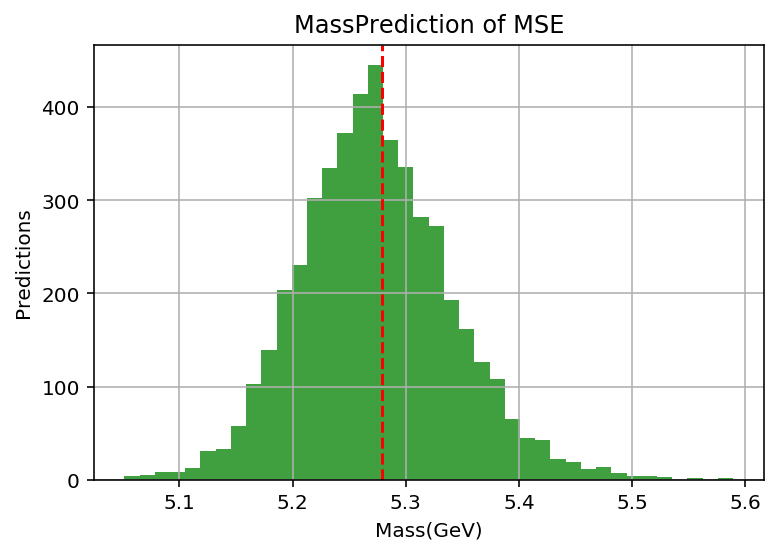

In [29]:
# PlotWithoutModel('30epochs/30predictions.txt', '30epochs/30masspre.png', 'Mass')